# [Amazon Reviews]

Process amazon reviews datasets

# Setup

## Library import
We import all the required Python libraries

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os,sys
import joblib
from os import path

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30


# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Local library import
We import all the required local libraries libraries

In [5]:
# Include local library paths
import sys
# add project folders so local libraries can be imported
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))
sys.path.insert(1, os.path.join(os.getcwd()  , '../src'))

In [6]:
# notebook misc functions
# def pretty_print(df):
#     return display( HTML( df.to_html().replace("\\n","<br>") ) )

def displayAll(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):	
        display(df)  

# import textwrap
import pprint
def wrap_print(txt):
    # print(textwrap.wrap(txt))
    print(pprint.pprint(txt, width=160))

# Parameter and functions definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [7]:
from tqdm import tqdm
from time import sleep
import traceback
import requests
from scipy import stats

In [8]:
def load_df(fpath, sep='\t', print_log=True, index_col=0, **kwargs):
    if not index_col is None:
        df = pd.read_csv(fpath, sep=sep, index_col=[index_col], **kwargs)
    else:
        df = pd.read_csv(fpath, sep=sep, **kwargs)
    if print_log:
        print(df.shape)
        print(df.columns)
        display(df.head())
    return df

In [9]:
def truncate_txt(txt, max_seq):
    ws = txt.split()
    t = ' '.join( ws[:max_seq]) if len(ws) > max_seq else txt
    return t

def hf_infer(query, txt, max_seq=480, debug=False):
    try:

        output = query({
            # "inputs": [truncate_txt(t, max_seq) for t in txt] if isinstance(txt, list) else truncate_txt(txt, max_seq) ,
            "inputs": txt ,
            # "parameters": {"truncation": True}
            })
        if debug:
            print(f"{txt[:-50]}-->  {output}")
        return output
    except Exception as err:
        print(f"Problem--> {err}")
        traceback.print_exc() 
    pass

def hf_infer_batch(df:pd.DataFrame, query, input_col_name, output_col_name, max_seq=480, chunks=None):
    chunks = chunks if chunks else max(int(len(df)/10), 1)
    rs_df = []
    i = 0
    for dftmp in tqdm(np.array_split(df, chunks), total=chunks):        
        try:
            dftmp[output_col_name] = hf_infer(query, txt=dftmp[input_col_name].values.tolist(), max_seq=max_seq, debug=i<3)
            i+=1
        except Exception as err:
            print(f"Problem--> {err}")
            # sleep(0.5)
            pass
        rs_df.append(dftmp)
    
    return rs_df

    


# Data import and pre-processing
Read Amazon reviews, combine meta-info and generate combined file

In [10]:
import json
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


# Adding meta-features

In [9]:
df = load_df("../out/paanx_preprocessed.tsv")

(1930, 4)
Index(['text', 'source', 'class', 'tokeep'], dtype='object')


,text,source,class,tokeep
0,i have been dealing with these for quite some ...,Quora,panic,1
1,"i was walking to school, but was running late ...",Quora,panic,1
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1
4,it feels like your body turns into a black hol...,Quora,panic,1


### Process with Mental Roberta (stressed?)

In [10]:
import requests

API_URL = "https://api-inference.huggingface.co/models/mental/mental-roberta-base"
headers = {"Authorization": "Bearer hf_..."} 

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()
	

In [11]:
API_URL = "https://api-inference.huggingface.co/models/mental/mental-roberta-base"
headers = {"Authorization": "Bearer hf_..."} 


In [106]:
df["instruction"] =  df.text.map(
    lambda v: f"Post: {v[:350]}\n\nConsider this post on social media to answer the question: The poster of this post experiencing <mask>.")
df.head()

,text,source,class,tokeep,instruction
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running..."
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran..."
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f..."
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...


In [150]:
print(df.iloc[0].instruction)

Post: i have been dealing with these for quite some time now, so i'll drop my two cents. i shall break this into bullet points. if you're reading this, please read with all your heart. and please share this with anybody who might need it!firstly, the difference between panic attacks and anxiety attacks— anxiety is something that intensifies over time and

Consider this post on social media to answer the question: The poster of this post experiencing <mask>.


In [119]:

dftmp = df.copy()
tgtcol = "mentalrobertaeval"
dftmp[tgtcol] = None
for i, row in tqdm(enumerate(dftmp.iterrows()), total=len(dftmp)):
    rs = hf_infer(query, row[1]["instruction"], max_seq=250)
    dftmp.at[row[0], tgtcol] = rs

dftmp[tgtcol] = dftmp[tgtcol].map(lambda v: v[0] if isinstance(v, list) else {})


display(dftmp)

 79%|███████▊  | 1517/1930 [13:49<03:57,  1.74it/s]Traceback (most recent call last):
  File "/home/owlmx/miniconda3/envs/misinfofastcatch/lib/python3.8/site-packages/requests/models.py", line 910, in json
    return complexjson.loads(self.text, **kwargs)
  File "/home/owlmx/miniconda3/envs/misinfofastcatch/lib/python3.8/json/__init__.py", line 357, in loads
    return _default_decoder.decode(s)
  File "/home/owlmx/miniconda3/envs/misinfofastcatch/lib/python3.8/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/home/owlmx/miniconda3/envs/misinfofastcatch/lib/python3.8/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_91763/3335944442.py", line 9, in hf_infer
    output = query({
 

Problem--> [Errno Expecting value] <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
</body>
</html>
: 0


100%|██████████| 1930/1930 [17:24<00:00,  1.85it/s]


,text,source,class,tokeep,instruction,mentalrobertaeval
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...,{}
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running...",{}
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran...",{}
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f...",{}
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...,{}
...,...,...,...,...,...,...
1925,i decided not to take the prescription medicat...,Reddit,anxiety,1,Post: i decided not to take the prescription m...,"{'score': 0.3258158266544342, 'token': 6943, '..."
1926,speaking to your doctor will help but the most...,Reddit,anxiety,1,Post: speaking to your doctor will help but th...,"{'score': 0.3044068217277527, 'token': 6882, '..."
1927,lorazepam. i only take it as needed (sparingly...,Reddit,anxiety,1,Post: lorazepam. i only take it as needed (spa...,"{'score': 0.2606504261493683, 'token': 6882, '..."
1928,hi there. block your social media for a days a...,Reddit,anxiety,1,Post: hi there. block your social media for a ...,"{'score': 0.8879285454750061, 'token': 6882, '..."


In [121]:
dftmp.mentalrobertaeval.value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           57
{'score': 0.29403504729270935, 'token': 6882, 'token_str': ' anxiety', 'sequence': 'Post: follow the 3-3-3 rule start by looking around you and naming three things you can see. then listen. what three sounds do you hear? next, move three parts of your body, such as your fingers, toes, or clench and release your shoulders. normally, the rule of threes contains the following: you can survive three minutes without breathable air (unconscio

In [123]:
dftmp = pd.concat([dftmp, pd.DataFrame.from_records( dftmp[tgtcol].values)[["score", "token_str"]]], axis=1)
dftmp.rename({"score": f"{tgtcol}_score", "token_str": f"{tgtcol}_label"}, axis=1, inplace=True)


In [126]:
dftmp

,text,source,class,tokeep,instruction,mentalrobertaeval,mentalrobertaeval_score,mentalrobertaeval_label
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...,{},NaN,NaN
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running...",{},NaN,NaN
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran...",{},NaN,NaN
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f...",{},NaN,NaN
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...,{},NaN,NaN
...,...,...,...,...,...,...,...,...
1925,i decided not to take the prescription medicat...,Reddit,anxiety,1,Post: i decided not to take the prescription m...,"{'score': 0.3258158266544342, 'token': 6943, '...",0.325816,depression
1926,speaking to your doctor will help but the most...,Reddit,anxiety,1,Post: speaking to your doctor will help but th...,"{'score': 0.3044068217277527, 'token': 6882, '...",0.304407,anxiety
1927,lorazepam. i only take it as needed (sparingly...,Reddit,anxiety,1,Post: lorazepam. i only take it as needed (spa...,"{'score': 0.2606504261493683, 'token': 6882, '...",0.260650,anxiety
1928,hi there. block your social media for a days a...,Reddit,anxiety,1,Post: hi there. block your social media for a ...,"{'score': 0.8879285454750061, 'token': 6882, '...",0.887929,anxiety


In [127]:
dftmp.to_csv("../out/hfinf_mentalroberta_experiencing.tsv", sep="\t")

In [89]:
dftmp.stress = dftmp.stress.map(lambda v: v[0] if isinstance(v, list) else {}) #.iloc[10][0]
dftmp

,text,source,class,tokeep,instruction,stress
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...,"{'score': 0.5528748631477356, 'token': 117, 't..."
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running...","{'score': 0.44880592823028564, 'token': 4420, ..."
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran...","{'score': 0.47384822368621826, 'token': 117, '..."
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f...","{'score': 0.4656566381454468, 'token': 117, 't..."
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...,"{'score': 0.4818416237831116, 'token': 117, 't..."
...,...,...,...,...,...,...
1925,i decided not to take the prescription medicat...,Reddit,anxiety,1,Post: i decided not to take the prescription m...,"{'score': 0.4514749050140381, 'token': 117, 't..."
1926,speaking to your doctor will help but the most...,Reddit,anxiety,1,Post: speaking to your doctor will help but th...,"{'score': 0.4376969039440155, 'token': 117, 't..."
1927,lorazepam. i only take it as needed (sparingly...,Reddit,anxiety,1,Post: lorazepam. i only take it as needed (spa...,"{'score': 0.43151605129241943, 'token': 117, '..."
1928,hi there. block your social media for a days a...,Reddit,anxiety,1,Post: hi there. block your social media for a ...,"{'score': 0.46455150842666626, 'token': 4420, ..."


In [95]:
dftmp = pd.concat([dftmp, pd.DataFrame.from_records( dftmp.stress.values)[["score", "token_str"]]], axis=1)
dftmp.rename({"score": "stress_score", "token_str": "stress_label"}, axis=1, inplace=True)
dftmp

,text,source,class,tokeep,instruction,stress,score,token_str
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...,"{'score': 0.5528748631477356, 'token': 117, 't...",0.552875,no
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running...","{'score': 0.44880592823028564, 'token': 4420, ...",0.448806,yes
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran...","{'score': 0.47384822368621826, 'token': 117, '...",0.473848,no
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f...","{'score': 0.4656566381454468, 'token': 117, 't...",0.465657,no
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...,"{'score': 0.4818416237831116, 'token': 117, 't...",0.481842,no
...,...,...,...,...,...,...,...,...
1925,i decided not to take the prescription medicat...,Reddit,anxiety,1,Post: i decided not to take the prescription m...,"{'score': 0.4514749050140381, 'token': 117, 't...",0.451475,no
1926,speaking to your doctor will help but the most...,Reddit,anxiety,1,Post: speaking to your doctor will help but th...,"{'score': 0.4376969039440155, 'token': 117, 't...",0.437697,no
1927,lorazepam. i only take it as needed (sparingly...,Reddit,anxiety,1,Post: lorazepam. i only take it as needed (spa...,"{'score': 0.43151605129241943, 'token': 117, '...",0.431516,no
1928,hi there. block your social media for a days a...,Reddit,anxiety,1,Post: hi there. block your social media for a ...,"{'score': 0.46455150842666626, 'token': 4420, ...",0.464552,yes


In [96]:
dftmp.rename({"score": "stress_score", "token_str": "stress_label"}, axis=1, inplace=True)
dftmp

,text,source,class,tokeep,instruction,stress,stress_score,stress_label
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...,"{'score': 0.5528748631477356, 'token': 117, 't...",0.552875,no
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running...","{'score': 0.44880592823028564, 'token': 4420, ...",0.448806,yes
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran...","{'score': 0.47384822368621826, 'token': 117, '...",0.473848,no
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f...","{'score': 0.4656566381454468, 'token': 117, 't...",0.465657,no
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...,"{'score': 0.4818416237831116, 'token': 117, 't...",0.481842,no
...,...,...,...,...,...,...,...,...
1925,i decided not to take the prescription medicat...,Reddit,anxiety,1,Post: i decided not to take the prescription m...,"{'score': 0.4514749050140381, 'token': 117, 't...",0.451475,no
1926,speaking to your doctor will help but the most...,Reddit,anxiety,1,Post: speaking to your doctor will help but th...,"{'score': 0.4376969039440155, 'token': 117, 't...",0.437697,no
1927,lorazepam. i only take it as needed (sparingly...,Reddit,anxiety,1,Post: lorazepam. i only take it as needed (spa...,"{'score': 0.43151605129241943, 'token': 117, '...",0.431516,no
1928,hi there. block your social media for a days a...,Reddit,anxiety,1,Post: hi there. block your social media for a ...,"{'score': 0.46455150842666626, 'token': 4420, ...",0.464552,yes


In [97]:
dftmp.to_csv("../out/paanx_mentalroberta_stress.tsv", sep="\t")

In [129]:
dftmp.mentalrobertaeval_label.value_counts()

 anxiety        1630
 depression      102
 panic            20
 fear             19
 stress           16
                ... 
 drowning          1
 happiness         1
 love              1
 abandonment       1
 allergies         1
Name: mentalrobertaeval_label, Length: 54, dtype: int64

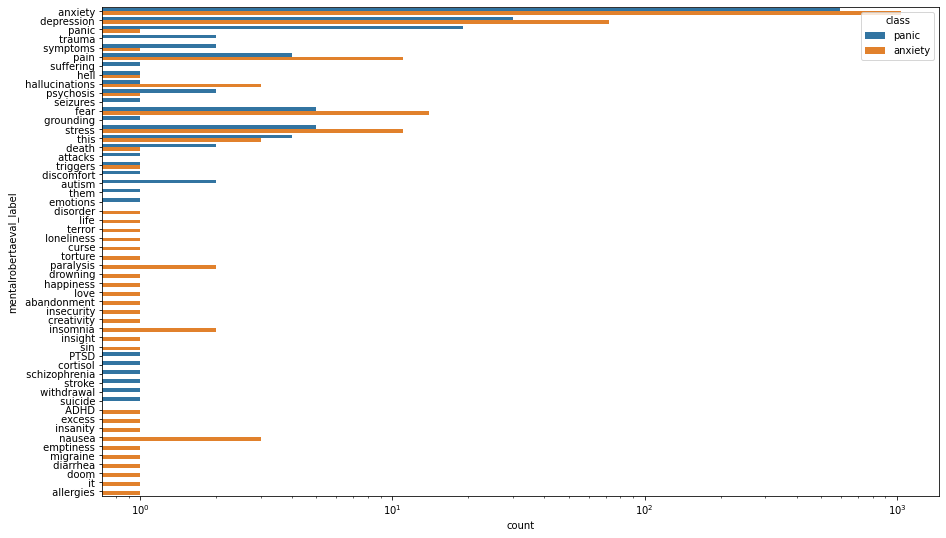

In [26]:
plt.figure(figsize=(15,9))
sns.countplot(data= dftmp[~dftmp.mentalrobertaeval_label.isna()][["class", "mentalrobertaeval_label"]], hue="class", y="mentalrobertaeval_label")
plt.xscale("log")
plt.show()


In [11]:
dftmp2 = load_df("../out/paanx_mentalroberta_stress.tsv")

(1930, 8)
Index(['text', 'source', 'class', 'tokeep', 'instruction', 'stress',
       'stress_score', 'stress_label'],
      dtype='object')


,text,source,class,tokeep,instruction,stress,stress_score,stress_label
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...,"{'score': 0.5528748631477356, 'token': 117, 't...",0.552875,no
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running...","{'score': 0.44880592823028564, 'token': 4420, ...",0.448806,yes
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran...","{'score': 0.47384822368621826, 'token': 117, '...",0.473848,no
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f...","{'score': 0.4656566381454468, 'token': 117, 't...",0.465657,no
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...,"{'score': 0.4818416237831116, 'token': 117, 't...",0.481842,no


In [14]:
dftmp2.stress_label.value_counts()

 no     1435
 yes     467
Name: stress_label, dtype: int64

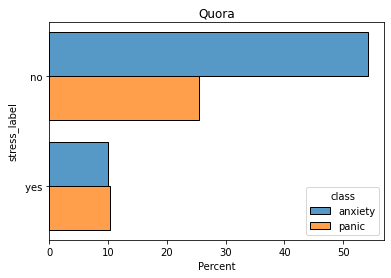

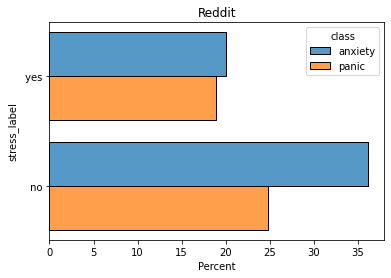

In [166]:
for gk, gv in dftmp2.groupby(by=["source"]):
    sns.histplot(data= gv[["stress_label", "class"]], y="stress_label", hue="class", hue_order=["anxiety", "panic"],
                 stat="percent", multiple="dodge", shrink=.8)
    plt.title(f"{gk}")
    plt.show()


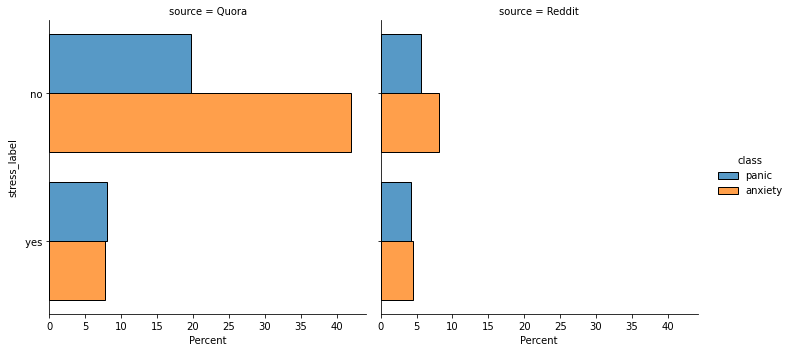

In [175]:
sns.displot(data=dftmp2[["source", "stress_label", "class"]], y="stress_label", hue="class", col="source", stat="percent", multiple="dodge", shrink=.8)
# plt.ylabel("Stress")
plt.show()

In [152]:
pd.concat([dftmp2, dftmp[["mentalrobertaeval",	"mentalrobertaeval_score", "mentalrobertaeval_label"]]], axis=1).to_csv("../out/hfinf_mentalroberta_full.tsv", sep='\t')

### Extract sentiment

In [173]:
import requests

API_URL = "https://api-inference.huggingface.co/models/lxyuan/distilbert-base-multilingual-cased-sentiments-student"
headers = {"Authorization": "Bearer hf_..."} 

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()
	

In [176]:
hf_infer(query, exs[0])

[[{'label': 'neutral', 'score': 0.3533730208873749},
  {'label': 'negative', 'score': 0.3360978066921234},
  {'label': 'positive', 'score': 0.3105291426181793}]]

In [135]:
rs_df = hf_infer_batch(df, query, output_col_name="sentiment", max_seq=400, chunks=180)
print(f"{len(rs_df)}")

 22%|██▏       | 39/180 [00:23<01:25,  1.64it/s]

Problem--> Length of values (2) does not match length of index (5)


 29%|██▉       | 53/180 [00:31<01:06,  1.91it/s]

Problem--> Length of values (2) does not match length of index (5)


 34%|███▍      | 62/180 [00:36<01:04,  1.82it/s]

Problem--> Length of values (2) does not match length of index (5)


 37%|███▋      | 66/180 [00:39<01:09,  1.64it/s]

Problem--> Length of values (2) does not match length of index (5)


 43%|████▎     | 78/180 [00:47<01:07,  1.51it/s]

Problem--> Length of values (2) does not match length of index (5)


 46%|████▌     | 82/180 [00:50<01:03,  1.55it/s]

Problem--> Length of values (2) does not match length of index (5)


 47%|████▋     | 84/180 [00:51<01:10,  1.36it/s]

Problem--> Length of values (2) does not match length of index (5)


 48%|████▊     | 87/180 [00:54<01:07,  1.37it/s]

Problem--> Length of values (2) does not match length of index (5)


 51%|█████     | 92/180 [00:58<01:03,  1.39it/s]

Problem--> Length of values (2) does not match length of index (5)


 64%|██████▍   | 116/180 [01:13<00:40,  1.58it/s]

Problem--> Length of values (1) does not match length of index (5)


 65%|██████▌   | 117/180 [01:14<00:44,  1.43it/s]

Problem--> Length of values (1) does not match length of index (5)


 66%|██████▌   | 118/180 [01:15<00:46,  1.34it/s]

Problem--> Length of values (1) does not match length of index (5)


 66%|██████▌   | 119/180 [01:16<00:46,  1.31it/s]

Problem--> Length of values (1) does not match length of index (5)


 67%|██████▋   | 120/180 [01:17<00:47,  1.26it/s]

Problem--> Length of values (1) does not match length of index (5)


 67%|██████▋   | 121/180 [01:18<00:47,  1.23it/s]

Problem--> Length of values (1) does not match length of index (5)


 68%|██████▊   | 122/180 [01:18<00:47,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 68%|██████▊   | 123/180 [01:19<00:47,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 69%|██████▉   | 124/180 [01:20<00:46,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 69%|██████▉   | 125/180 [01:21<00:46,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 70%|███████   | 126/180 [01:22<00:44,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 71%|███████   | 127/180 [01:23<00:44,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 71%|███████   | 128/180 [01:23<00:43,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 72%|███████▏  | 129/180 [01:24<00:42,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 72%|███████▏  | 130/180 [01:25<00:41,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 73%|███████▎  | 131/180 [01:26<00:40,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 73%|███████▎  | 132/180 [01:27<00:40,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 74%|███████▍  | 133/180 [01:28<00:39,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 74%|███████▍  | 134/180 [01:28<00:38,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 75%|███████▌  | 135/180 [01:29<00:37,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 76%|███████▌  | 136/180 [01:30<00:36,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 76%|███████▌  | 137/180 [01:31<00:36,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 77%|███████▋  | 138/180 [01:32<00:35,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 77%|███████▋  | 139/180 [01:33<00:34,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 78%|███████▊  | 140/180 [01:33<00:33,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 78%|███████▊  | 141/180 [01:34<00:32,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 79%|███████▉  | 142/180 [01:35<00:31,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 79%|███████▉  | 143/180 [01:36<00:30,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 80%|████████  | 144/180 [01:37<00:29,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 81%|████████  | 145/180 [01:38<00:28,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 81%|████████  | 146/180 [01:38<00:27,  1.22it/s]

Problem--> Length of values (1) does not match length of index (5)


 82%|████████▏ | 147/180 [01:39<00:27,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 82%|████████▏ | 148/180 [01:40<00:26,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 83%|████████▎ | 149/180 [01:41<00:25,  1.22it/s]

Problem--> Length of values (1) does not match length of index (5)


 83%|████████▎ | 150/180 [01:42<00:24,  1.21it/s]

Problem--> Length of values (1) does not match length of index (5)


 84%|████████▍ | 151/180 [01:43<00:24,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 84%|████████▍ | 152/180 [01:43<00:23,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 85%|████████▌ | 153/180 [01:44<00:22,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 86%|████████▌ | 154/180 [01:45<00:21,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 86%|████████▌ | 155/180 [01:46<00:20,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 87%|████████▋ | 156/180 [01:47<00:20,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 87%|████████▋ | 157/180 [01:48<00:19,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 88%|████████▊ | 158/180 [01:48<00:18,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 88%|████████▊ | 159/180 [01:49<00:17,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 89%|████████▉ | 160/180 [01:50<00:16,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 89%|████████▉ | 161/180 [01:51<00:15,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 90%|█████████ | 162/180 [01:52<00:14,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 91%|█████████ | 163/180 [01:53<00:14,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 91%|█████████ | 164/180 [01:53<00:13,  1.18it/s]

Problem--> Length of values (1) does not match length of index (5)


 92%|█████████▏| 165/180 [01:54<00:12,  1.18it/s]

Problem--> Length of values (1) does not match length of index (5)


 92%|█████████▏| 166/180 [01:55<00:11,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 93%|█████████▎| 167/180 [01:56<00:11,  1.18it/s]

Problem--> Length of values (1) does not match length of index (5)


 93%|█████████▎| 168/180 [01:57<00:10,  1.16it/s]

Problem--> Length of values (1) does not match length of index (5)


 94%|█████████▍| 169/180 [01:58<00:09,  1.16it/s]

Problem--> Length of values (1) does not match length of index (5)


 94%|█████████▍| 170/180 [01:59<00:08,  1.16it/s]

Problem--> Length of values (1) does not match length of index (5)


 95%|█████████▌| 171/180 [01:59<00:07,  1.17it/s]

Problem--> Length of values (1) does not match length of index (5)


 96%|█████████▌| 172/180 [02:00<00:06,  1.18it/s]

Problem--> Length of values (1) does not match length of index (5)


 96%|█████████▌| 173/180 [02:01<00:05,  1.20it/s]

Problem--> Length of values (1) does not match length of index (5)


 97%|█████████▋| 174/180 [02:02<00:05,  1.19it/s]

Problem--> Length of values (1) does not match length of index (5)


 97%|█████████▋| 175/180 [02:03<00:04,  1.18it/s]

Problem--> Length of values (1) does not match length of index (5)


 98%|█████████▊| 176/180 [02:04<00:03,  1.17it/s]

Problem--> Length of values (1) does not match length of index (5)


 98%|█████████▊| 177/180 [02:05<00:02,  1.16it/s]

Problem--> Length of values (1) does not match length of index (5)


 99%|█████████▉| 178/180 [02:05<00:01,  1.15it/s]

Problem--> Length of values (1) does not match length of index (4)


 99%|█████████▉| 179/180 [02:06<00:00,  1.15it/s]

Problem--> Length of values (1) does not match length of index (4)


100%|██████████| 180/180 [02:07<00:00,  1.41it/s]

535 180


In [138]:
df = pd.concat(rs_df, axis=0)
df

,asin,overall,summary,reviewText,category,description,sentiment
0,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425..."
1,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425..."
2,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866..."
3,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866..."
4,B00005N7P0,5.0,Best PC Magazine,In my mind BEST PC Magazine for upgrades / har...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.792497694492..."
...,...,...,...,...,...,...,...
893,B01CF3ECNK,3.0,"I hate to admit it, but...","Against my better judgment, I picked up an iss...","['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,NaN
894,B01CF3ECNK,3.0,Everyday.....,"A fun magazine to read through but for me, the...","['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,NaN
895,B01CF3ECNK,5.0,Really well put together,I first saw this magazine at my dentist's offi...,"['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,NaN
896,B01CF3ECNK,5.0,Love this magazine,This magazine is fun and upbeat. The pictures ...,"['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,NaN


In [197]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    if not isinstance(row['sentiment'], list) and pd.isna(row['sentiment']):
        df.at[index, 'sentiment'] = hf_infer(query, row["reviewText"], max_seq=400)
        pass

100%|██████████| 898/898 [02:21<00:00,  6.37it/s] 


In [199]:
df[df.sentiment.isna()]

,asin,overall,summary,reviewText,category,description,sentiment


In [7]:
# df.to_csv("../data/data/amazon_reviews_v2/processed_magazine-subscriptions_sentiment.tsv", sep="\t")
df = pd.read_csv("../data/data/amazon_reviews_v2/processed_magazine-subscriptions_sentiment.tsv", sep="\t")
print(df.shape)
df.head()

(898, 10)


,Unnamed: 0,asin,overall,summary,reviewText,category,description,sentiment,reviewText_tmp,reviewText_tmp_len
0,0,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425...","I'm old, and so is my computer. Any advice tha...",32
1,1,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425...","I'm old, and so is my computer. Any advice tha...",32
2,2,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866...",When PC Magazine ceased publication of their p...,136
3,3,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866...",When PC Magazine ceased publication of their p...,136
4,4,B00005N7P0,5.0,Best PC Magazine,In my mind BEST PC Magazine for upgrades / har...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.792497694492...",In my mind BEST PC Magazine for upgrades / har...,17


In [243]:
tmp = df.sentiment.map(lambda v: len(v))
tmp

0      3
1      3
2      3
3      3
4      3
      ..
893    3
894    3
895    3
896    3
897    2
Name: sentiment, Length: 898, dtype: int64

In [282]:
for index, row in df[[isinstance(v, list) and len(v) <3 for v in df.sentiment]].iterrows():
    df.at[index, "sentiment"] = row["sentiment"][0]


In [249]:
df["reviewText_tmp"] = df.reviewText.map(lambda v: ' ' .join(v.split()[:400]))
df

,asin,overall,summary,reviewText,category,description,sentiment,reviewText_tmp
0,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425...","I'm old, and so is my computer. Any advice tha..."
1,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425...","I'm old, and so is my computer. Any advice tha..."
2,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866...",When PC Magazine ceased publication of their p...
3,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866...",When PC Magazine ceased publication of their p...
4,B00005N7P0,5.0,Best PC Magazine,In my mind BEST PC Magazine for upgrades / har...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.792497694492...",In my mind BEST PC Magazine for upgrades / har...
...,...,...,...,...,...,...,...,...
893,B01CF3ECNK,3.0,"I hate to admit it, but...","Against my better judgment, I picked up an iss...","['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'negative', 'score': 0.576227664947...","Against my better judgment, I picked up an iss..."
894,B01CF3ECNK,3.0,Everyday.....,"A fun magazine to read through but for me, the...","['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'neutral', 'score': 0.4259364902973...","A fun magazine to read through but for me, the..."
895,B01CF3ECNK,5.0,Really well put together,I first saw this magazine at my dentist's offi...,"['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'positive', 'score': 0.698858737945...",I first saw this magazine at my dentist's offi...
896,B01CF3ECNK,5.0,Love this magazine,This magazine is fun and upbeat. The pictures ...,"['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'positive', 'score': 0.736666321754...",This magazine is fun and upbeat. The pictures ...


In [251]:
df["reviewText_tmp_len"] = [len(t.split()) for t in df.reviewText_tmp]
df

,asin,overall,summary,reviewText,category,description,sentiment,reviewText_tmp,reviewText_tmp_len
0,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425...","I'm old, and so is my computer. Any advice tha...",32
1,B00005N7P0,4.0,Cheapskates guide,"I'm old, and so is my computer. Any advice th...","['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.922463059425...","I'm old, and so is my computer. Any advice tha...",32
2,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866...",When PC Magazine ceased publication of their p...,136
3,B00005N7P0,5.0,Excellent Computer Magazine,When PC Magazine ceased publication of their p...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.596512436866...",When PC Magazine ceased publication of their p...,136
4,B00005N7P0,5.0,Best PC Magazine,In my mind BEST PC Magazine for upgrades / har...,"['Magazine Subscriptions', 'Technology', 'Comp...",MAXIMUM PC is the ultimate upgrade for the sav...,"[{'label': 'positive', 'score': 0.792497694492...",In my mind BEST PC Magazine for upgrades / har...,17
...,...,...,...,...,...,...,...,...,...
893,B01CF3ECNK,3.0,"I hate to admit it, but...","Against my better judgment, I picked up an iss...","['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'negative', 'score': 0.576227664947...","Against my better judgment, I picked up an iss...",85
894,B01CF3ECNK,3.0,Everyday.....,"A fun magazine to read through but for me, the...","['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'neutral', 'score': 0.4259364902973...","A fun magazine to read through but for me, the...",38
895,B01CF3ECNK,5.0,Really well put together,I first saw this magazine at my dentist's offi...,"['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'positive', 'score': 0.698858737945...",I first saw this magazine at my dentist's offi...,90
896,B01CF3ECNK,5.0,Love this magazine,This magazine is fun and upbeat. The pictures ...,"['Magazine Subscriptions', 'Cooking, Food & Wi...",Rachael Ray Every Day is a food and cooking ma...,"[{'label': 'positive', 'score': 0.736666321754...",This magazine is fun and upbeat. The pictures ...,74


In [281]:
df[(df.sentiment.str.len() < 3)]

,asin,overall,summary,reviewText,category,description,sentiment,reviewText_tmp,reviewText_tmp_len
464,B00005NIPP,1.0,Don't do it! -- Pick one of these magazines in...,Maxim rode the men's magazine gold rush in the...,"['Magazine Subscriptions', 'Fashion & Style', ...",Maxim is the essential guide for today's activ...,"[[{'label': 'negative', 'score': 0.62371635437...",Maxim rode the men's magazine gold rush in the...,232


In [280]:
for index, row in df[[len(v) <3 for v in df.sentiment]].iterrows():
    df.at[index, 'sentiment'] = hf_infer(query, row["reviewText_tmp"], max_seq=250)

In [277]:
wrap_print(df.iloc[464].reviewText[:900])

("Maxim rode the men's magazine gold rush in the late 1990s, leading Stuff, FHM and a host of other PG-13 fare that filled the convenience store racks as "
 'Playboy, Penthouse and the hard cores were either dropped completely or were tucked behind the clerk hidden behind individual black plastic wrappers.\n'
 '\n'
 "Maxim is the last Laddie still in print in the U.S., having witnessed the print burials for FHM (1996 to 2007) and Stuff (1998 to 2007). Maxim's "
 'putrefaction is evident to its subscribers, hence the heavily discounted subscriber rates available today. If you were unfortunate enough to receive a gift '
 "subscription to Maxim or, worse yet, bought one for yourself, you can no doubt bear witness to the decay. The magazine simply isn't interesting or "
 'compelling to read. You could find more of everything - women, entertainment, food and fashion - in a 10-minute Google search.\n'
 '\n'
 'Ask yourself, why are')
None


In [279]:
df.at[464,"reviewText_tmp"] = df.iloc[464].reviewText[:900]

### Plot

In [15]:

dftmp = load_df("../out/hfinf_mentalroberta_experiencing.tsv")

(1930, 8)
Index(['text', 'source', 'class', 'tokeep', 'instruction', 'mentalrobertaeval',
       'mentalrobertaeval_score', 'mentalrobertaeval_label'],
      dtype='object')


,text,source,class,tokeep,instruction,mentalrobertaeval,mentalrobertaeval_score,mentalrobertaeval_label
0,i have been dealing with these for quite some ...,Quora,panic,1,Post: i have been dealing with these for quite...,{},NaN,NaN
1,"i was walking to school, but was running late ...",Quora,panic,1,"Post: i was walking to school, but was running...",{},NaN,NaN
2,"for me, panic attacks come two ways: randomly ...",Quora,panic,1,"Post: for me, panic attacks come two ways: ran...",{},NaN,NaN
3,"i’m driving home, riding a tingly high from sa...",Quora,panic,1,"Post: i’m driving home, riding a tingly high f...",{},NaN,NaN
4,it feels like your body turns into a black hol...,Quora,panic,1,Post: it feels like your body turns into a bla...,{},NaN,NaN


In [16]:

dftmp = dftmp.dropna()
dftmp

,text,source,class,tokeep,instruction,mentalrobertaeval,mentalrobertaeval_score,mentalrobertaeval_label
27,i haven't read all of the answers but most are...,Quora,panic,1,Post: i haven't read all of the answers but mo...,"{'score': 0.5356575846672058, 'token': 6882, '...",0.535658,anxiety
28,i just experienced my third panic attack which...,Quora,panic,1,Post: i just experienced my third panic attack...,"{'score': 0.8256316781044006, 'token': 6882, '...",0.825632,anxiety
29,i've had a number of them over the years. eith...,Quora,panic,1,Post: i've had a number of them over the years...,"{'score': 0.3047427833080292, 'token': 6882, '...",0.304743,anxiety
30,this is my personal experience with panic atta...,Quora,panic,1,Post: this is my personal experience with pani...,"{'score': 0.7653297781944275, 'token': 6882, '...",0.765330,anxiety
31,a trip to the er i learned conscious calming a...,Quora,panic,1,Post: a trip to the er i learned conscious cal...,"{'score': 0.2477901130914688, 'token': 6882, '...",0.247790,anxiety
...,...,...,...,...,...,...,...,...
1925,i decided not to take the prescription medicat...,Reddit,anxiety,1,Post: i decided not to take the prescription m...,"{'score': 0.3258158266544342, 'token': 6943, '...",0.325816,depression
1926,speaking to your doctor will help but the most...,Reddit,anxiety,1,Post: speaking to your doctor will help but th...,"{'score': 0.3044068217277527, 'token': 6882, '...",0.304407,anxiety
1927,lorazepam. i only take it as needed (sparingly...,Reddit,anxiety,1,Post: lorazepam. i only take it as needed (spa...,"{'score': 0.2606504261493683, 'token': 6882, '...",0.260650,anxiety
1928,hi there. block your social media for a days a...,Reddit,anxiety,1,Post: hi there. block your social media for a ...,"{'score': 0.8879285454750061, 'token': 6882, '...",0.887929,anxiety


In [18]:
dftmp.mentalrobertaeval_label.value_counts().reset_index()

,index,mentalrobertaeval_label
0,anxiety,1630
1,depression,102
2,panic,20
3,fear,19
4,stress,16
...,...,...
49,drowning,1
50,happiness,1
51,love,1
52,abandonment,1


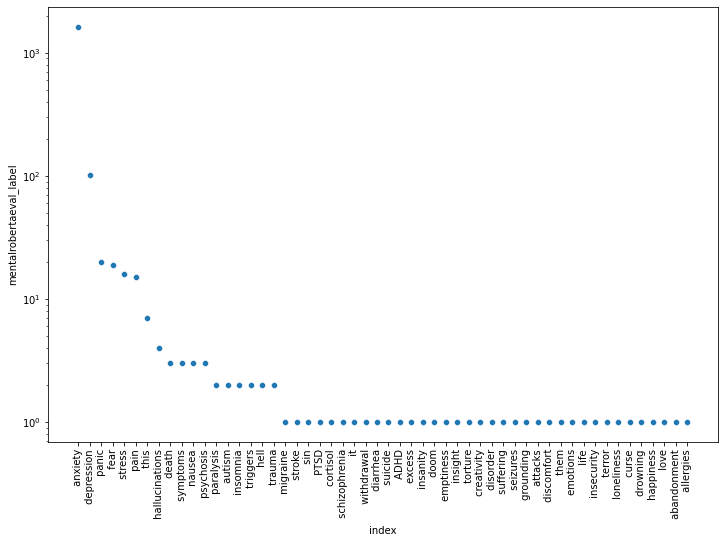

In [29]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=dftmp.mentalrobertaeval_label.value_counts().reset_index(), x="index", y="mentalrobertaeval_label")
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

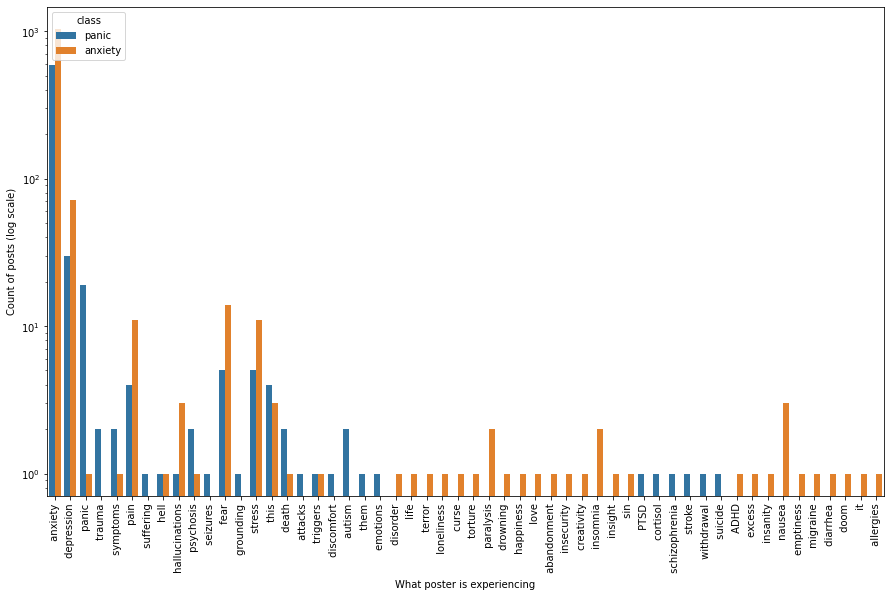

In [33]:
plt.figure(figsize=(15,9))
sns.countplot(data= dftmp[~dftmp.mentalrobertaeval_label.isna()][["class", "mentalrobertaeval_label"]], hue="class", x="mentalrobertaeval_label")
plt.yscale("log")
plt.xticks(rotation=90)
plt.xlabel("What poster is experiencing")
plt.ylabel("Count of posts (log scale)")
plt.show()